# Spinning Disc Master 

## Sources of code
1) Apeer_micro. "Tutorial 57 - Nuclei (cell) segmentation in python using watershed." https://www.youtube.com/watch?v=M1mJsJ5M4iE
<br> 
2) Apeer_micro. "Introductory python tutorials for image processing." https://github.com/bnsreenu/python_for_image_processing_APEER
<br>
3) Open Source Computer Vision in Python. 
https://docs.opencv.org/4.x/d6/d00/tutorial_py_root.html
<br> 
4) Pandas Documentation.
https://pandas.pydata.org/docs/reference/index.html
<br> 
5) Scipy Documentation.
https://scipy.org/
<br> 
6) Seaborn Documentation.
https://seaborn.pydata.org/
<br> 
7) Jupyter Notebook Documentation.
https://jupyter-notebook.readthedocs.io/en/stable/
<br> 
8) Numpy Documentation.
https://numpy.org/doc/
<br> 
9) Scikit-image processing Documentation.
https://scikit-image.org/docs/dev/api/skimage.measure.html
<br> 
10) Math documentation.
https://docs.python.org/3/library/math.html
<br> 

## General workflow of processing a single coverslip
0) Extract the blue channel of the image and allow the user to draw the circular region of interest (ROI).
<br>
1) Create a mask using the selected ROI.
<br>
2) Get the sure background of the image.
<br>
3) Find the sure foreground of the image.
<br>
4) Find the unknown, ambiguous parts of the image by subtracting the sure background from the sure foreground.
<br>
5) Create markers for cells based on their connectivity of the pixels.
<br>
6) Adjust the sure background to 10 and unknown to 0 so watershed segmentation can identify these areas better.
<br>
7) Perform watershed segmentation and produce markers of where cells are.
<br>
8) Measure the cell properties using Sci-kit image processing (i.e. area, equivalent_diameter, centroid) and convert area and equivalent_diameter in pixels to um using the scaling factor 1/0.625 (1 pixel = 0.625 um).
<br>
9) Get the approximate coordinates of each nuclei using the centroid of each cell.
<br>
10) Approximate the center of the coverslip as the center of the image.
<br>
11) Calculate the distance of each nuclei relative to the center.
<br>
12) Define the radial segments (default is N = 100 radial segments) for counting cells.
<br>
13) Count the number of cells within each radial segment for an area count.
<br>
14) Calculate the shear force using the specified RPM and the surface area of each radial segment.
<br>
15) Calculate the density of cells by dividing the number of cells in each radial segment by the surface area of each radial segment.
<br>
16) Normalize the density of cells by dividing by the max density of cells.
<br>
17) Plot the cell density (cells per $cm^2$) against the radius ($\mu m$) of the coverslip, cell density (cells per $cm^2$) against the shear force (dynes per $cm^2$), normalized cell density against the shear force (dynes per $cm^2$).
<br>
18) Fit a sigmoidal curve using the shear force and normalized cell density data.
<br>
19) Calculate the $\tau_{50}$ using the fit parameters from the sigmoidal curve.
<br>
20) Export the shear force and normalized cell density data for analyzing multiple coverslips.
<br>

## Import libraries for use

In [480]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from scipy.optimize import curve_fit
from skimage import measure, color, io
import pandas as pd
from math import pi
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons
%matplotlib widget

## Define recurring functions

### Function for updating the circle that the user draws

In [484]:
def update(val):
    r1 = slider_r1.val
    c_x = slider_c_x.val
    c_y  = slider_c_y.val
    circ.center = c_x, c_y
    circ.set_radius(r1) 
    fig.canvas.draw_idle()

### Function for scaling the images displayed to save time and resources

In [487]:
def scale(image, scale_percent):
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    dim = (width, height)

    # resize image
    resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
    return resized

## Image processing section (steps 0-7)

### Allow the user to draw a circle to define the region of interest (ROI)

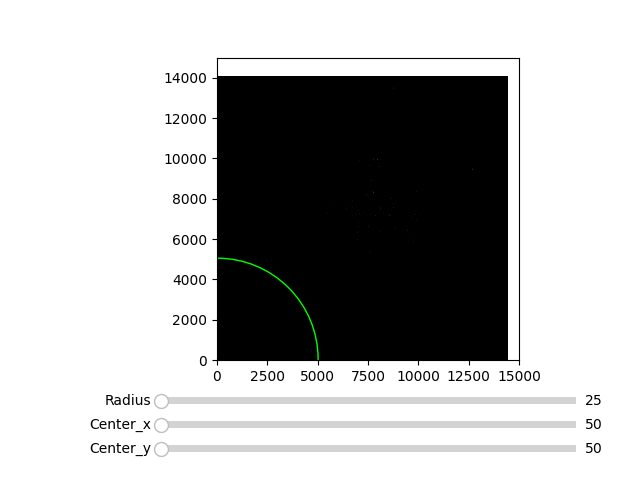

In [493]:
img = cv2.imread("/Volumes/Abhi Disk/Lab Work/03_09_25 Extended Co-culture 72hr and 96hr/72hr co-culture/Post-education/36hrs/Edu vIII v2 by wt wt V2 3.5k/6 PS 0.85.tif")
#Extract only blue channel as DAPI / nuclear (blue) staining is the best
#channel to perform cell count.
cells=img[:,:,0]  #Blue channel. Image equivalent to grey image.


fig, ax = plt.subplots()
ax.imshow(scale(cells, 50), cmap="gray")
plt.subplots_adjust(left=0.25, bottom=0.25)
ax.axis([0, 15000, 0, 15000])
ax.set_aspect("equal")

axcolor = 'skyblue'
sl1 = plt.axes([0.25, 0.15, 0.65, 0.03], facecolor=axcolor)
sl2 = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
sl3 = plt.axes([0.25, 0.05, 0.65, 0.03], facecolor=axcolor)

slider_r1 = Slider(sl1, 'Radius', 0.0, 15000, valinit=25)
slider_c_x = Slider(sl2, 'Center_x', 0.0, 15000, valinit=50)
slider_c_y = Slider(sl3, 'Center_y', 0.0, 15000, valinit=50)

circ = plt.Circle((25,50), 5000, ec="lime", facecolor="none")
ax.add_patch(circ)

slider_r1.on_changed(update)
slider_c_x.on_changed(update)
slider_c_y.on_changed(update)

plt.show()

In [495]:
r1 = slider_r1.val
c_x = slider_c_x.val
c_y  = slider_c_y.val

radius = int(r1 * 2)
c_x = int(c_x * 2)
c_y = int(c_y * 2)

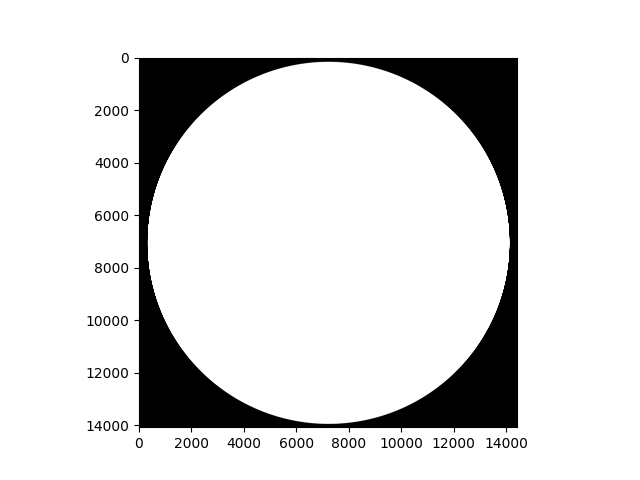

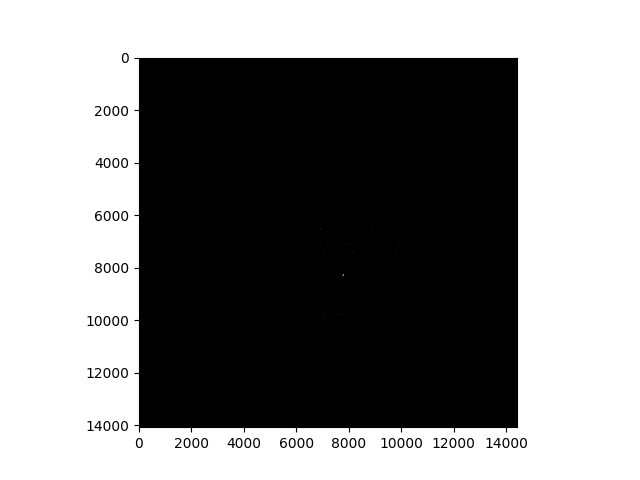

In [497]:
#Threshold image to binary using OTSU. ALl thresholded pixels will be set to 255
ret1, thresh = cv2.threshold(cells, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)


# Morphological operations to remove small noise - opening
#To remove holes we can use closing
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# now, let's make a circular mask with a radius of 100 pixels and
# apply the mask again
mask = np.zeros(opening.shape[:2], dtype="uint8")
cv2.circle(mask, (c_x, c_y), radius, 255, -1)
masked = cv2.bitwise_and(opening, opening, mask=mask)

# Plot mask and masked image
plt.figure("Mask")
plt.imshow(scale(mask, 50), cmap="gray")
plt.figure("Masked image")
plt.imshow(scale(masked, 50), cmap="gray")

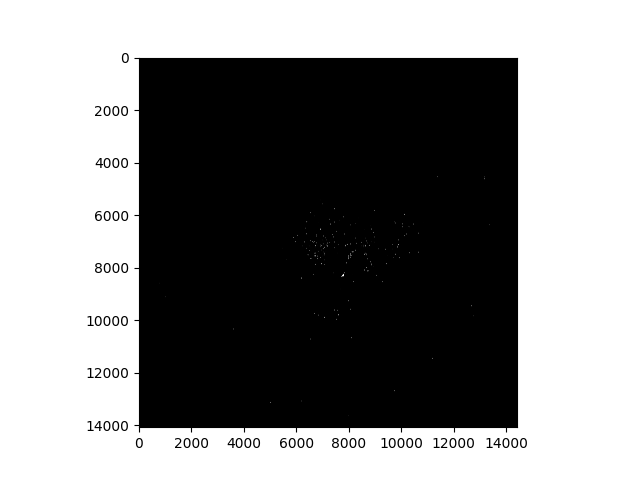

In [498]:
#Check the total regions found before and after applying this. 

#STEP 1: Sure background 
#Now we know that the regions at the center of cells is for sure cells
#The region far away is background.
#We need to extract sure regions. For that erode a few times. 
#But we have cells touching, so erode alone will not work. 
#To separate touching objects, the best approach would be distance transform and then thresholding.

# let us start by identifying sure background area
# dilating pixes a few times increases cell boundary to background. 
# This way whatever is remaining for sure will be background. 
#The area in between sure background and foreground is our ambiguous area. 
#Watershed should find this area for us. 
sure_bg = cv2.dilate(masked,kernel,iterations=10)
plt.figure()
plt.imshow(scale(sure_bg, 50), cmap='gray') #Dark region is our sure background

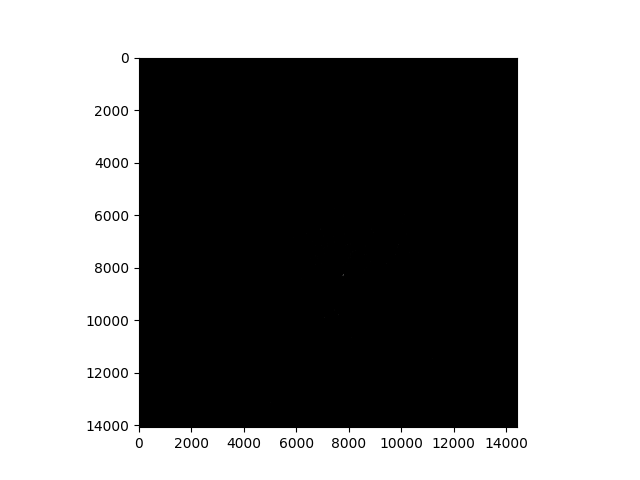

In [499]:
# Finding sure foreground area using distance transform and thresholding
#intensities of the points inside the foreground regions are changed to 
#distance their respective distances from the closest 0 value (boundary).
#https://www.tutorialspoint.com/opencv/opencv_distance_transformation.htm
dist_transform = cv2.distanceTransform(masked,cv2.DIST_C,5)
plt.figure()
plt.imshow(scale(dist_transform, 50), cmap='gray') #Dist transformed img. 

10.0


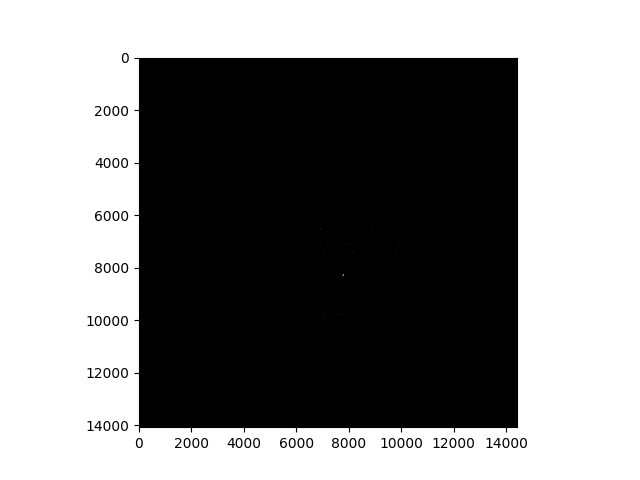

In [500]:
#Let us threshold the dist transform by starting at 1/2 its max value.
print(dist_transform.max()) #gives about 21.9
ret2, sure_fg = cv2.threshold(masked,0.5*dist_transform.max(),255,0)
plt.figure()
plt.imshow(scale(sure_fg, 50), cmap='gray')

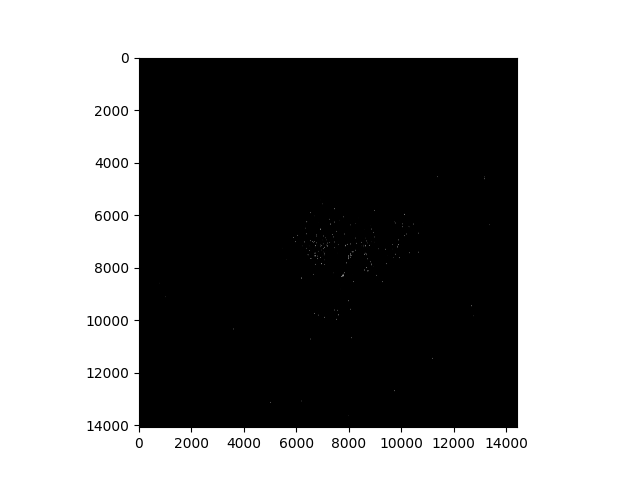

In [501]:
#Later you realize that 0.25* max value will not separate the cells well.
#High value like 0.7 will not recognize some cells. 0.5 seems to be a good compromize

# Unknown ambiguous region is nothing but bkground - foreground
sure_fg = np.uint8(sure_fg)  #Convert to uint8 from float
sure_bg = np.uint8(sure_bg)
unknown = cv2.subtract(sure_bg,sure_fg)
plt.figure()
plt.imshow(scale(unknown, 50), cmap='gray')

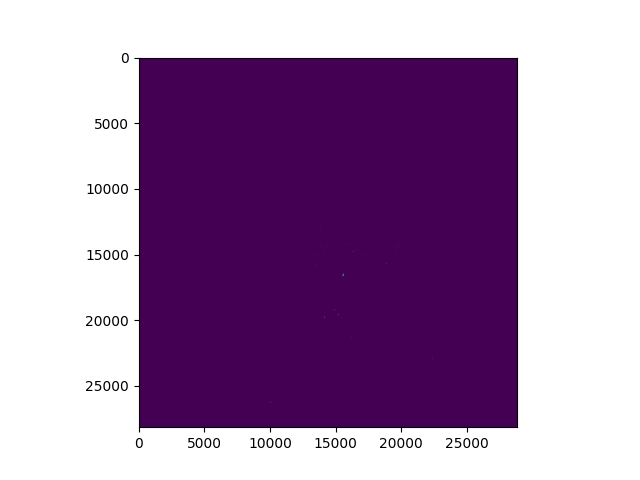

In [502]:
#Now we create a marker and label the regions inside. 
# For sure regions, both foreground and background will be labeled with positive numbers.
# Unknown regions will be labeled 0. 
#For markers let us use ConnectedComponents. 
#Connected components labeling scans an image and groups its pixels into components 
#based on pixel connectivity, i.e. all pixels in a connected component share 
#similar pixel intensity values and are in some way connected with each other. 
#Once all groups have been determined, each pixel is labeled with a graylevel 
# or a color (color labeling) according to the component it was assigned to.
ret3, markers = cv2.connectedComponents(sure_fg)
plt.figure()
plt.imshow(markers)

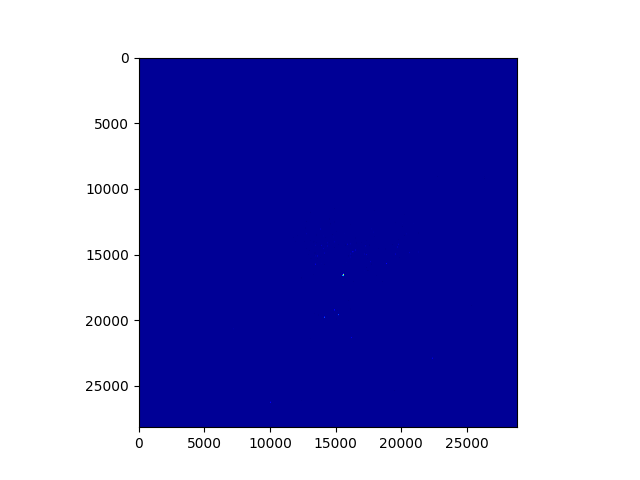

In [503]:
#One problem rightnow is that the entire background pixels is given value 0.
#This means watershed considers this region as unknown.
#So let us add 10 to all labels so that sure background is not 0, but 10
markers = markers+10

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
plt.figure()
plt.imshow(markers, cmap='jet')   #Look at the 3 distinct regions.

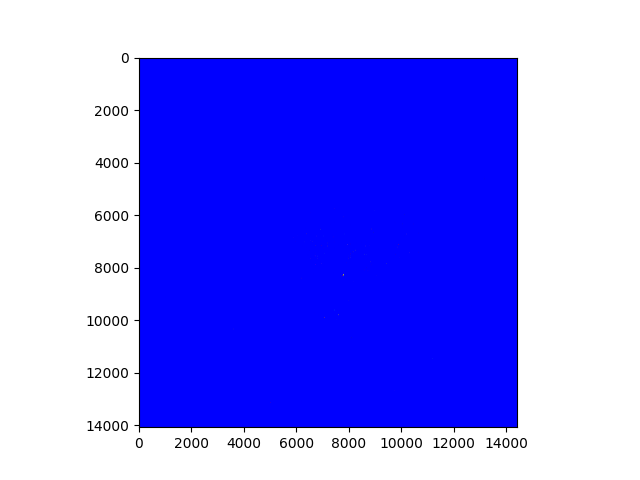

In [504]:
#Now we are ready for watershed filling. 
markers = cv2.watershed(img,markers)

#Let us color boundaries in yellow. 
#Remember that watershed assigns boundaries a value of -1
img[markers == -1] = [0,255,255]  

#label2rgb - Return an RGB image where color-coded labels are painted over the image.
img2 = color.label2rgb(markers, bg_label=0)
plt.figure()
plt.imshow(scale(img2,50))
cv2.imshow('Overlay on original image', scale(img, 50))
cv2.imshow('Colored Grains', scale(img2, 50))

## Measure properties of the cells (step 8)

In [506]:
props = measure.regionprops_table(markers, cells, 
                          properties=['label',
                                      'area', 'equivalent_diameter','centroid'])

df = pd.DataFrame(props)

In [507]:
orig_px_um = 0.75
img_scale = 0.85 # 1.0 if not resized, 0.75 if 75 %, 0.50 if 50 %
pixel_um = orig_px_um / img_scale 

df['area_sq_microns'] = df['area'] * (pixel_um ** 2)
df['equivalent_diameter_microns'] = df['equivalent_diameter'] * pixel_um


## Get the nuclei of each cell using the centroid (step 9)

In [509]:
nuclei_coord = []
for row in df.iterrows():
    (x0, y0) = (float(row[1]["centroid-0"]), float(row[1]["centroid-1"]))
    nuclei_coord.append((x0,y0))

## Get the distance of each nuclei to the center of the coverslip (steps 10-11) 

In [512]:
nuclei_coord = []
for row in df.iterrows():
    (x0, y0) = (float(row[1]["centroid-0"]), float(row[1]["centroid-1"]))
    nuclei_coord.append((x0,y0))

In [513]:
center_coords = (img2.shape[0]/2,img2.shape[1]/2)

In [514]:
distance_from_center = []
for nuclei in nuclei_coord:
    distance = ((nuclei[0] - center_coords[0])**2+(nuclei[1] - center_coords[1])**2)**(1/2)
    distance_from_center.append(distance)
distance_from_center = [d * pixel_um for d in distance_from_center]

## Define the radial segments of the coverslip and count how many cells are in each segment (steps 12-13)

In [516]:
radial_segments = [0, 12500/150**(1/2)]
for i in range (2,150):
    radial_segments.append((12500**2/150+radial_segments[i-1]**2)**(1/2))
radial_segments.append(12500)

In [517]:
area_count = [0 for i in range(len(radial_segments))]
for i in range(len(distance_from_center)):
    for l in range(len(radial_segments) - 1):
        if ((radial_segments[l] < distance_from_center[i]) and (radial_segments[l + 1] > distance_from_center[i])):
            area_count[l] += 1

## Calculate the shear force and surface area (step 14)

In [519]:
shear_force = []
surface_area = []
radius = []

for l in range(150):
    shear_force.append(4/5*radial_segments[l+1]*10**(-4)*(0.007*(3500*0.1047)**3)**(1/2))
    surface_area.append(pi*((radial_segments[l+1])**2-(radial_segments[l])**2)*1e-8)

## Calculate the density of cells and normalize the density (steps 15-16)

In [521]:
cell_density = []
for area in range(len(surface_area)):
    cell_density.append(area_count[area]/surface_area[area])
norm_cell_density = [cell/max(cell_density) for cell in cell_density]

## Plot the distributions (step 17)

Text(0, 0.5, 'Cell density (cells per $cm^2$)')

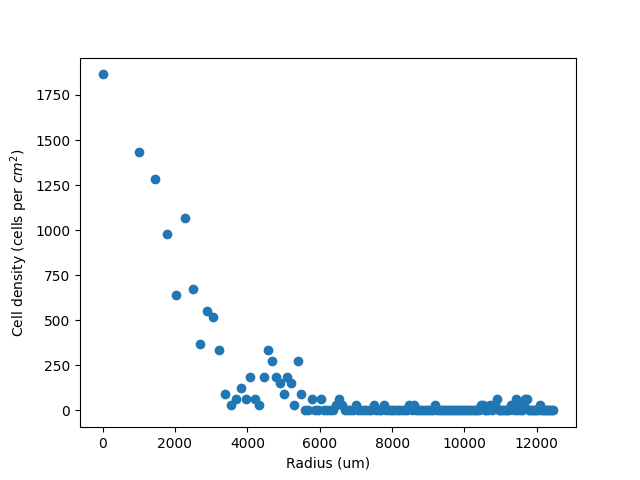

In [523]:
plt.figure()
plt.scatter(radial_segments[:150], cell_density)
plt.xlabel("Radius (um)")
plt.ylabel("Cell density (cells per $cm^2$)")

Text(0, 0.5, 'Cell density (cells per $cm^2$)')

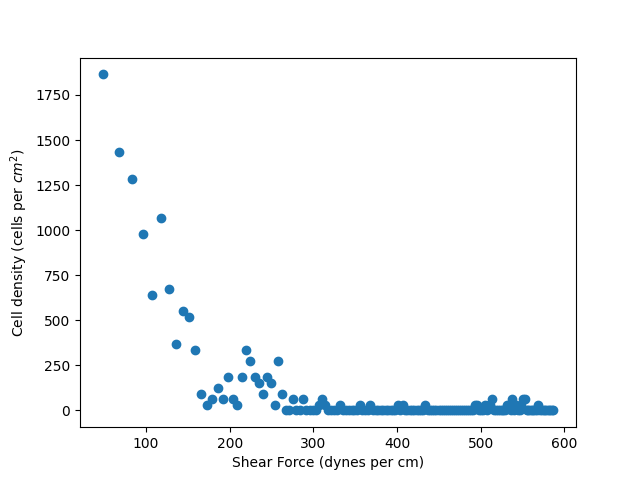

In [524]:
plt.figure()
plt.scatter(shear_force, cell_density)
plt.xlabel("Shear Force (dynes per cm)")
plt.ylabel("Cell density (cells per $cm^2$)")

Text(0, 0.5, 'Normalized Cell density (cells per $cm^2$)')

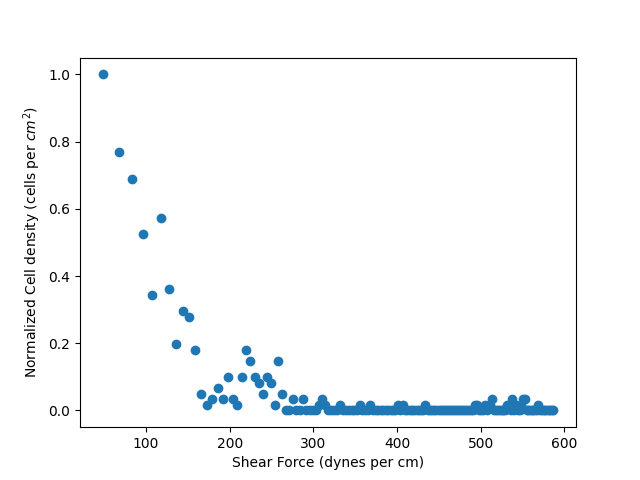

In [526]:
plt.figure()
plt.scatter(shear_force, norm_cell_density)
plt.xlabel("Shear Force (dynes per cm)")
plt.ylabel("Normalized Cell density (cells per $cm^2$)")

## Fit a sigmoidal curve (step 18)

In [528]:
def sigmoid(x, x0, k, b):
    y = 1 / (1 + np.exp(k*(x-x0))) + b
    return (y)

p0 = [np.median(shear_force), 1, min(norm_cell_density)] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, shear_force, norm_cell_density,p0)
for value in popt:
    print(value)
    
residuals = norm_cell_density - sigmoid(shear_force, *popt);
ss_res = np.sum(residuals**2);
ss_tot = np.sum((norm_cell_density-np.mean(norm_cell_density))**2);
r_squared = 1 - (ss_res / ss_tot);

print(r_squared)

105.27406978428237
0.0317735922466393
0.009236083423130816
0.9324882288103429


In [529]:
x = np.linspace(0, max(shear_force), len(shear_force))
y = sigmoid(x, *popt)
y = y/max(y)

## Calculate the tau50 using the sigmoidal curve fit values and plot the sigmoidal fit (step 19)

105.27289579654591


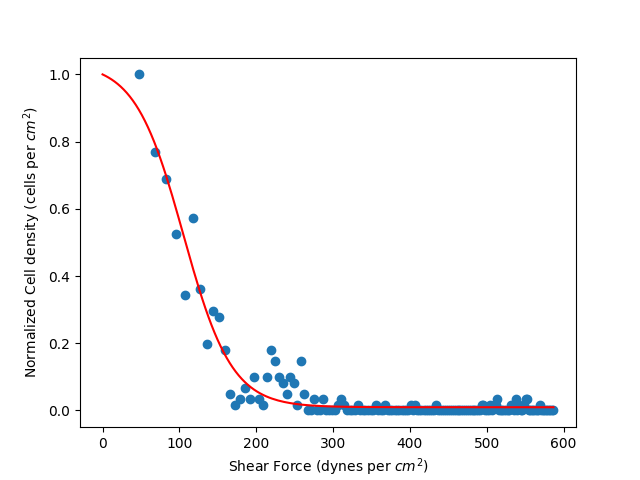

In [532]:
plt.figure()
plt.scatter(shear_force,norm_cell_density)
plt.plot(x, y, "r")
plt.xlabel("Shear Force (dynes per $cm^2$)")
plt.ylabel("Normalized Cell density (cells per $cm^2$)")
L = 1
x0 = popt[0]
k = popt[1]
b = popt[2]

t50 = -(np.log(((0.5-b)/1)**(-1) - 1)*k-x0)
print(t50)

## Export data for a single coverslip for analyzing multiple cover slips (step 20)

Plot Master

In [538]:
data_export = {
    "cell_density": norm_cell_density,
    "shear_force": shear_force
}
df_export = pd.DataFrame(data_export, columns=["cell_density","shear_force"])
df_export.to_csv("/Volumes/Abhi Disk/Lab Work/03_09_25 Extended Co-culture 72hr and 96hr/72hr co-culture/Post-education/36hrs/Edu vIII v2 by wt wt V2 3.5k/6 0.85 Data.csv")

In [559]:
#close all figures 
plt.close('all')

### General workflow of analyzing multiple coverslips
1) Load all the coverslip csv files 
<br>
2) Merge all the coverslip data into one pandas Dataframe
<br>
3) Normalize cell density using the new max cell density in the merged dataset
<br>
4) Fit data to a sigmoidal curve
<br>
5) Calculate the $\tau_{50}$ using the fit parameters from the sigmoidal curve

## Load all the coverslip csv files (step 1)

In [ ]:
df_2500 = pd.read_csv("2021-12-22_PTEN-noCM_2_NEW/2500RPM.csv")
df_3000 = pd.read_csv("2021-12-22_PTEN-noCM_2_NEW/3000RPM.csv")
df_4500 = pd.read_csv("2021-12-22_PTEN-noCM_2_NEW/4500RPM.csv")

## Merge all the coverslip data into one Dataframe (step 2)

In [ ]:
df_main = df_2500.merge(df_3000, how="outer")
df_main = df_main.merge(df_4500, how="outer")
df_main

## Normalize cell density again (step 3)

In [ ]:
cell_density = df_main["cell_density"]
shear_force = df_main["shear_force"]
max_cell_density = max(cell_density)
norm_cell_density = [cell/max_cell_density for cell in cell_density]

## Fit data to a sigmoidal curve (step 4)

In [ ]:
def sigmoid(x, x0, k, b):
    y = 1 / (1 + np.exp(k*(x-x0))) + b
    return (y)

p0 = [np.median(shear_force), 1, min(norm_cell_density)] # this is an mandatory initial guess

popt, pcov = curve_fit(sigmoid, shear_force, norm_cell_density,p0)
    
x = np.linspace(0, max(shear_force), len(shear_force))
y = sigmoid(x, *popt)
y = y/max(y)

## Calculate the $\tau_{50}$ (step 5)

In [ ]:
plt.figure()
plt.scatter(shear_force,norm_cell_density)
plt.plot(x, y, "r")
plt.xlabel("Shear Force (dynes per $cm^2$)")
plt.ylabel("Normalized Cell density (cells per $cm^2$)")
L = 1
x0 = popt[0]
k = popt[1]
b = popt[2]

t50 = -(np.log(((0.5-b)/1)**(-1) - 1)*k-x0)
print(t50)

# Attempts to get a heat map of the cell density with respect to the distance away from the center of the coverslip

In [ ]:
plt.figure()
plt.imshow(markers, cmap='hot')
plt.show()

In [ ]:
plt.figure()
ax = sns.heatmap(markers)

In [ ]:
heat_map = pd.DataFrame({"area_count": area_count, "radius_x": radial_segments, "radius_y": radial_segments})
heat_map = heat_map.pivot(index="radius_y",columns="radius_x",values="area_count")
heat_map = heat_map.fillna(1)

In [ ]:
plt.figure()
ax = sns.heatmap(heat_map)